**Test data name: colina.mat**
* Subject 1 is classified as control
* Subject 2 is classified as control
* Subject 3 is classified as patient
* Subject 4 is  classified as patient

#### Visual Psychophysics: Part I

In [2]:
# Import necessary libraries
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib.lines import Line2D
from matplotlib import colorbar, cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
import pandas as pd
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

##### 1) Construct a Kohonen network in order to carry out the classification of the vectors

\begin{bmatrix}
1 & 1&  0& 0\\ 
1 & 0 & 0 & 0\\ 
0 & 0 & 0 & 1\\ 
 0&0  & 1 & 1
\end{bmatrix}

In [3]:
# My data
data = np.array([[1, 1, 0, 0], 
                 [1, 0, 0, 0], 
                 [0, 0, 0, 1], 
                 [0, 0, 1, 1]])

Construct a network that is flexible in terms of the size of the input vector.  This will permit you to easily utilize the patient and healthy subject data.

Pay attention to the adjustment in the learning rate.  You may have to find the value that allows a convergence (i.e. synaptic weights that converge).

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.413522819375207e-07


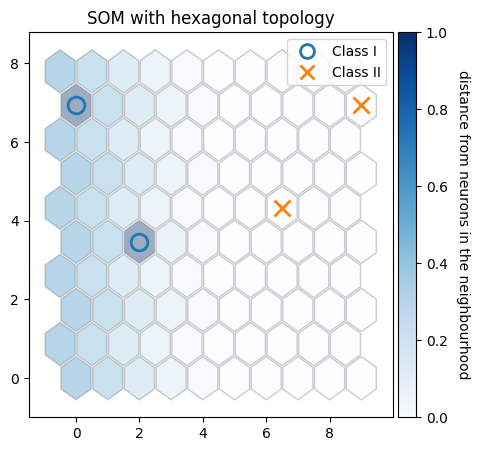

In [4]:
# Labels for my data
labels = np.array([0, 0, 1, 1])

# Initialize the SOM
som = MiniSom(10, 10, 4, sigma=0.3, learning_rate=0.1, topology='hexagonal', neighborhood_function='gaussian')

# Train the SOM
som.pca_weights_init(data)
som.train(data, 1000, verbose=True)
        
# Get the coordinates and the weights from the SOM
xx, yy = som.get_euclidean_coordinates()
weights = som.get_weights()

##### Plotting my training data
# Create a figure
plt.figure(figsize=(5,5))

# Add each hexagon to the plot
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)]*np.sqrt(3)/2
        hexagon = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=0.95/np.sqrt(3),
                                 facecolor=cm.Blues(weights[i, j][0]), alpha=0.4, edgecolor='gray')
        plt.gca().add_patch(hexagon)

# Add a marker per tag
markers = ['o', 'x']
colors = ['C0', 'C1']
for cnt, x in enumerate(data):
    w = som.winner(x) 
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy*np.sqrt(3)/2
    plt.plot(wx, wy, markers[labels[cnt]], markerfacecolor='None', 
             markeredgecolor=colors[labels[cnt]], markersize=12, markeredgewidth=2)

# Legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markeredgecolor='C0', label='Class I',
                          markersize=10, markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='w', markeredgecolor='C1', label='Class II',
                          markersize=10, markeredgewidth=2)]

# Add the legend to the graphic
plt.title('SOM with hexagonal topology')
plt.legend(handles=legend_elements, loc='upper right')

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',#5.413522819375207e-07
                  rotation=270, fontsize=10)#5.413522819375207e-07
plt.gcf().add_axes(ax_cb)
plt.show()

The SOM display shows the structure of the network, which remains constant once the network has been trained.

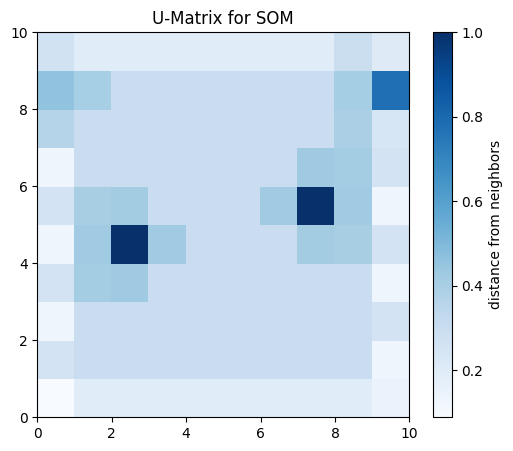

In [5]:
# plotting the distance map
plt.figure(figsize=(6,5))
plt.pcolor(som.distance_map().T, cmap='Blues')  
plt.colorbar(label='distance from neighbors')
plt.title('U-Matrix for SOM')
plt.show()

The U-Matrix shows the average distance between a neuron and its neighbors in the feature map.

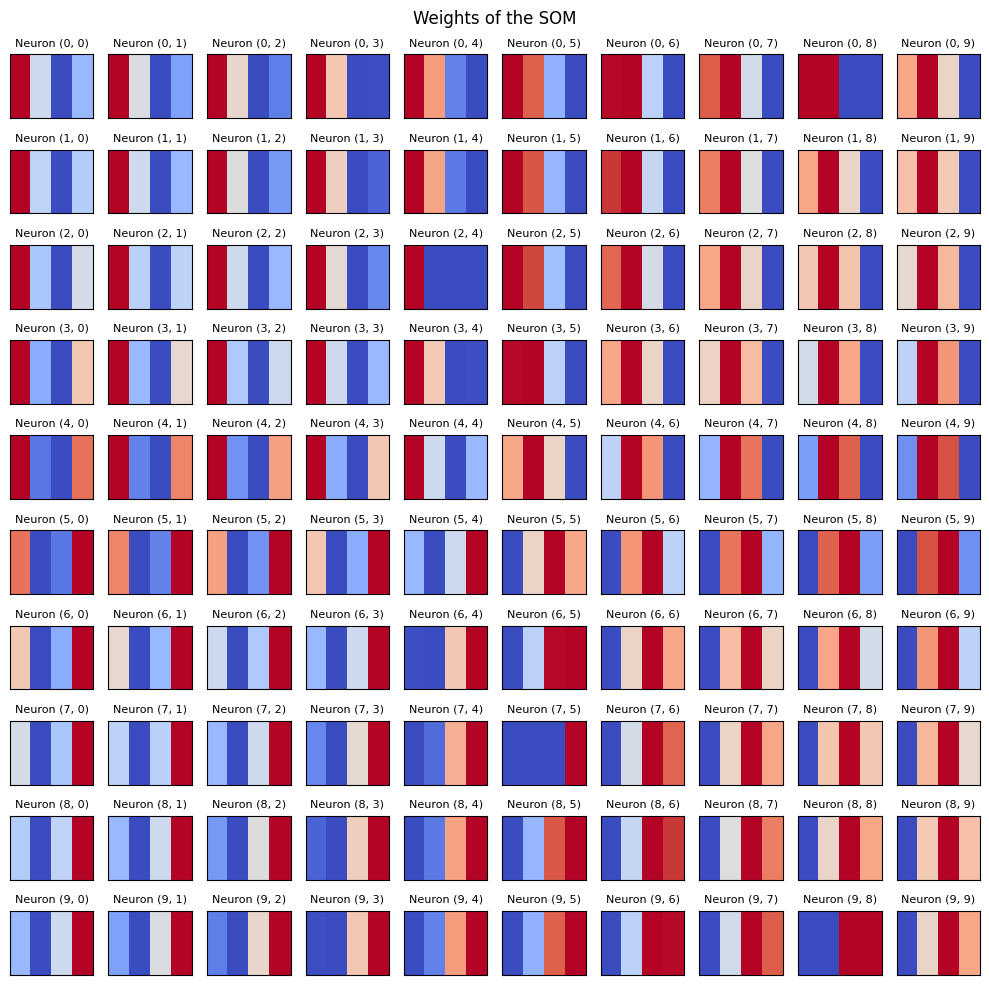

In [11]:
# Plot the weights of the SOM
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(10, 10, figure=fig)

for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(gs[i, j])
        plt.pcolor(weights[i][j].reshape(1, -1), cmap='coolwarm')
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Neuron ({i}, {j})',fontsize=8)

plt.suptitle('Weights of the SOM')
plt.tight_layout()
plt.show()

In [15]:
# Create a dictionary to store the labels of the data assigned to each neuron.
neuron_labels = {}

# For each training vector, find the winning neuron and store its label
for vec, label in zip(data, labels):
    winner = som.winner(vec)
    if winner not in neuron_labels:
        neuron_labels[winner] = []
    neuron_labels[winner].append(label)

# Assign the most frequent label to each neuron
for neuron in neuron_labels:
    neuron_labels[neuron] = max(set(neuron_labels[neuron]), key=neuron_labels[neuron].count)

In [16]:
for vec in data:
    winner = som.winner(vec)
    print(f"The vector {vec} is classified in neuron {winner} with label {neuron_labels[winner]}")

The vector [1 1 0 0] is classified in neuron (0, 8) with label 0
The vector [1 0 0 0] is classified in neuron (2, 4) with label 0
The vector [0 0 0 1] is classified in neuron (7, 5) with label 1
The vector [0 0 1 1] is classified in neuron (9, 8) with label 1


##### 2) Once the training is completed carry out a test with the vectors

\begin{bmatrix}
0 & 0&  0& 0.9\\ 
0 & 0 & 0.8 & 0.9\\ 
0.7 & 0 & 0 & 0\\ 
0.7& 0.9  & 0 & 0
\end{bmatrix}

As you might expect, the vectors (0, 0, 0, 0.9) and (0, 0, 0.8, 0.9) should fall in class II while the vectors (0.7, 0, 0, 0) and (0.7, 0.9, 0, 0) should fall in class I.


In [14]:
# Testing data
test_data = np.array([[0, 0, 0, 0.9], 
                      [0, 0, 0.8, 0.9], 
                      [0.7, 0, 0, 0], 
                      [0.7, 0.9, 0, 0]])

# Expected classification of test data
expected_labels = np.array([1, 1, 0, 0])

# Create an array to store the predicted tags
predicted_labels = []

# Now, for each vector of test data, find the winning neuron and assign the label of that neuron
for x in test_data:
    w = som.winner(x)
    predicted_labels.append(neuron_labels[w])

predicted_labels = np.array(predicted_labels)

# Compare predicted labels with expected labels
print("Expected labels: ", expected_labels)
print("Predicted labels: ", predicted_labels)

# Accuracy of classification
accuracy = np.sum(predicted_labels == expected_labels) / len(expected_labels)
print("Classification accuracy: ", accuracy)

Expected labels:  [1 1 0 0]
Predicted labels:  [1 1 0 0]
Classification accuracy:  1.0


In [9]:
for vec in test_data:
    winner = som.winner(vec)
    print(f"The vector {vec} is classified in neuron {winner} with label {neuron_labels[winner]}")

The vector [0.  0.  0.  0.9] is classified in neuron (7, 5) with label 1
The vector [0.  0.  0.8 0.9] is classified in neuron (9, 8) with label 1
The vector [0.7 0.  0.  0. ] is classified in neuron (2, 4) with label 0
The vector [0.7 0.9 0.  0. ] is classified in neuron (0, 8) with label 0


In [10]:
# Print the weight of the neuron at position (i, j)
i, j = 0, 8  
print("Weight of neuron at position ({}, {}):".format(i, j))
print(som.get_weights()[i, j])

Weight of neuron at position (0, 8):
[ 9.99999730e-01  9.99999947e-01  1.20765089e-07 -4.07578972e-07]


In [11]:
i, j = 2, 4 
print("Weight of neuron at position ({}, {}):".format(i, j))
print(som.get_weights()[i, j])

Weight of neuron at position (2, 4):
[ 9.99999541e-01  8.82751048e-08 -1.96677528e-07 -2.30531523e-07]


In [12]:
i, j = 7, 5 
print("Weight of neuron at position ({}, {}):".format(i, j))
print(som.get_weights()[i, j])

Weight of neuron at position (7, 5):
[-2.34692734e-07 -8.98685152e-08  2.00227657e-07  9.99999532e-01]


In [13]:
i, j = 9, 8
print("Weight of neuron at position ({}, {}):".format(i, j))
print(som.get_weights()[i, j])

Weight of neuron at position (9, 8):
[-4.30050882e-07  1.27423485e-07  9.99999944e-01  9.99999715e-01]


The vectors (1, 1, 0, 0) and (1, 0, 0, 0) from our training data are being classified into one class (neurons (0, 8) and (2, 4)), while the vectors (0, 0, 0, 1) and (0, 0, 1, 1) are being classified into another class (neurons (7, 5) and (9, 8)).

Similarly, the test vectors (0, 0, 0, 0.9) and (0, 0, 0.8, 0.9) are being classified into one class (neurons (7, 5) and (9, 8)), while the vectors (0.7, 0, 0, 0) and (0.7, 0.9, 0, 0) are being classified into another class (neurons (2, 4) and (0, 8)).

#### Module Human Psychophysics Part II

Train your Kohonen networks using the training data set that I am sending.  As to be expected, the ‘healthy.mat’ file contains data from healthy subjects and the ‘patient.mat’ contains patient data.  Each line corresponds to the data (time series) coming from one subject.  The time series is made up of the displacements of markers placed on the joints of subjects. There are ten subjects in each file.  Of course, the same markers are used for all subjects. You do not have to adjust anything in each time series as the information from each marker has already been put in the correct position in the time series. 

In [18]:
# Load training data 
healthy_data = pd.read_csv('healthy.csv')
patient_data = pd.read_csv('patient.csv')

In [19]:
# Display the first few rows of each data set to get an idea of their structure
print("Healthy data:")
print(healthy_data.head())
print("\nPatient data:")
print(patient_data.head())

Healthy data:
   VarName1  VarName2  VarName3  VarName4  VarName5  VarName6  VarName7  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   VarName8  VarName9  VarName10  ...  VarName641  VarName642  VarName643  \
0         0         0          0  ...           0           0           0   
1         0         0          0  ...           0           0           0   
2         0         0          0  ...           0           0           0   
3         0         0          0  ...           0           0           0   
4         0         0          0  ...           0           0           0   

   VarName644  VarName645  VarName646  VarName647  VarName648  VarName64

In [20]:
#Apply normalization
healthy_data = (healthy_data - np.mean(healthy_data, axis=0)) / np.std(healthy_data, axis=0)
patient_data = (patient_data - np.mean(patient_data, axis=0)) / np.std(patient_data, axis=0)

In [21]:
# Define data and labels
data2 = np.concatenate((healthy_data, patient_data))
labels2 = np.array([0]*len(healthy_data) + [1]*len(patient_data))

# Clean data from infs and NaNs
data2 = np.nan_to_num(data2)

# Initialize the SOM
som2 = MiniSom(10, 10, data2.shape[1], sigma=0.3, learning_rate=0.5, 
              topology='rectangular', neighborhood_function='gaussian')

# Train the SOM
som2.pca_weights_init(data2)
som2.train(data2, 1000, verbose=True)

# Create a dictionary to store the labels assigned to each neuron
neuron_labels2 = {}

# For each training vector, find the winning neuron and store its label
for vec, label in zip(data2, labels2):
    winner = som2.winner(vec)
    if winner not in neuron_labels2:
        neuron_labels2[winner] = []
    neuron_labels2[winner].append(label)

# Assign the most frequent label to each neuron
for neuron in neuron_labels2:
    neuron_labels2[neuron] = max(set(neuron_labels2[neuron]), key=neuron_labels2[neuron].count)

C:\Users\ksevi\anaconda3\envs\KOHONEN\lib\site-packages\minisom.py:384: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[:, pc_order[0]] + \


 [  327 / 1000 ]  33% - 0:00:00 left 

 [  632 / 1000 ]  63% - 0:00:00 left 

 [  938 / 1000 ]  94% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.1447556501202775e-06


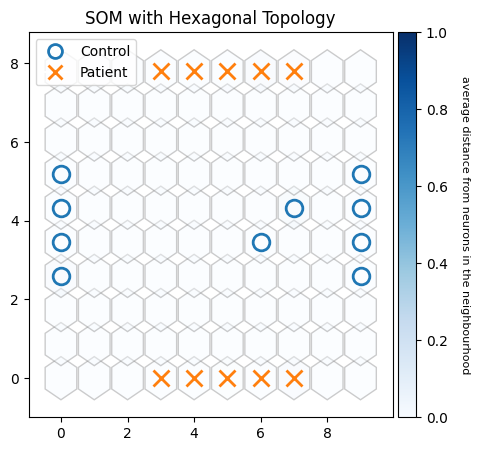

In [22]:
# Get the coordinates and the weights from the SOM
xx, yy = som2.get_euclidean_coordinates()
weights = som2.get_weights()

# Create a figure
plt.figure(figsize=(5,5))

# Add each hexagon to the plot
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)]*np.sqrt(3)/2
        hexagon = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=0.95/np.sqrt(3),
                                 facecolor=cm.Blues(weights[i, j].mean()), alpha=0.4, edgecolor='gray')
        plt.gca().add_patch(hexagon)

# Add a marker per label
markers = ['o', 'x']
colors = ['C0', 'C1']
for cnt, x in enumerate(data2):
    w = som2.winner(x) 
    wx, wy = som2.convert_map_to_euclidean(w) 
    wy = wy*np.sqrt(3)/2
    plt.plot(wx, wy, markers[labels2[cnt]], markerfacecolor='None', 
             markeredgecolor=colors[labels2[cnt]], markersize=12, markeredgewidth=2)

# Legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markeredgecolor='C0', label='Control',
                          markersize=10, markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='w', markeredgecolor='C1', label='Patient',
                          markersize=10, markeredgewidth=2)]

# Add the legend to the plot
plt.title('SOM with Hexagonal Topology')
plt.legend(handles=legend_elements, loc='upper left')

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('average distance from neurons in the neighbourhood',
                  rotation=270, fontsize=8)
plt.gcf().add_axes(ax_cb)
plt.show()

The SOM display shows the structure of the network, which remains constant once the network has been trained.

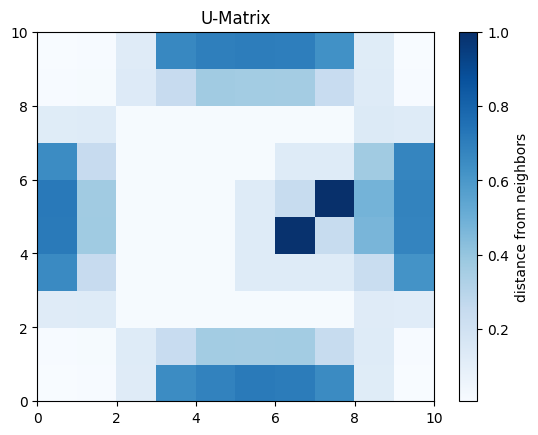

In [23]:
# transpose to match the orientation of the SOM
plt.pcolor(som2.distance_map().T, cmap='Blues')
plt.colorbar(label='distance from neighbors')
plt.title('U-Matrix')
plt.show()

The U-Matrix shows the average distance between a neuron and its neighbors in the feature map.

In [24]:
#Load test data
colina_data = pd.read_csv('colina.csv')
print("\nColina data:")
print(colina_data.head())


Colina data:
   VarName1  VarName2  VarName3  VarName4  VarName5  VarName6  VarName7  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   

   VarName8  VarName9  VarName10  ...  VarName641  VarName642  VarName643  \
0         0         0          0  ...           0           0           0   
1         0         0          0  ...           0           0           0   
2         0         0          0  ...           0           0           0   
3         0         0          0  ...           0           0           0   

   VarName644  VarName645  VarName646  VarName647  VarName648  VarName649  \
0           0           0           0           0           0           0   
1           0           0           0           0           0         

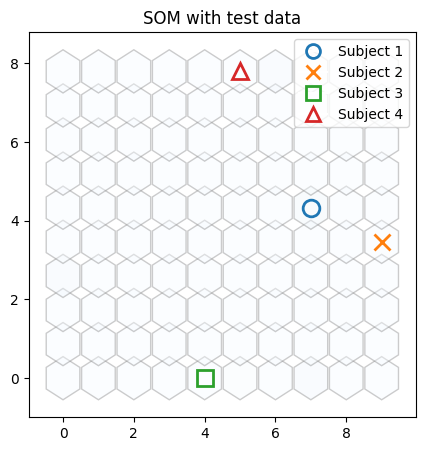

In [25]:
# Create a figure
plt.figure(figsize=(5,5))

# Add each hexagon to the plot
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)]*np.sqrt(3)/2
        hexagon = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=0.95/np.sqrt(3),
                                 facecolor=cm.Blues(weights[i, j].mean()), alpha=0.4, edgecolor='gray')
        plt.gca().add_patch(hexagon)


# Define a list of markers and colors for each subject
markers = ['o', 'x', 's', '^', 'D']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Ensure data are all numeric
colina_data_numeric = colina_data.select_dtypes(include=[np.number])

# Mark the position of the testing data
for cnt, x in enumerate(colina_data_numeric.values):
    w = som2.winner(x) 
    wx, wy = som2.convert_map_to_euclidean(w) 
    wy = wy*np.sqrt(3)/2
    plt.plot(wx, wy, markers[cnt % len(markers)], markerfacecolor='None', 
             markeredgecolor=colors[cnt % len(colors)], markersize=12, markeredgewidth=2)

# Add legend
legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='w', label=f'Subject {i+1}',
                          markerfacecolor='None', markeredgecolor=colors[i % len(colors)], markersize=10, markeredgewidth=2) 
                   for i in range(colina_data_numeric.shape[0])]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('SOM with test data')
plt.show()

As you can see, subjects 3 and 4 are in the same position as the patients, as well as subjects 1 and 2 are in the same position as the control subjects.

In [22]:
# Dictionary to map the numerical labels to categories
label_dict = {0: 'control', 1: 'patient'}

# Classification of the data in 'colina.csv'
for i, vec in enumerate(colina_data.values):
    winner_coli = som2.winner(vec)
    print(f"Subject {i+1} is classified in neuron {winner_coli} which is labelled as {label_dict[neuron_labels2[winner_coli]]}")

Subject 1 is classified in neuron (7, 5) which is labelled as control
Subject 2 is classified in neuron (9, 4) which is labelled as control
Subject 3 is classified in neuron (4, 0) which is labelled as patient
Subject 4 is classified in neuron (5, 9) which is labelled as patient


#### K Means and K Nearest Neighbor (KNN) comparison - Part III

In [23]:
# Load data
healthy_data = pd.read_csv('healthy.csv')
patient_data = pd.read_csv('patient.csv')

# Combine healthy and patient data
data = pd.concat([patient_data, healthy_data])

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Create labels: 0 for patient, 1 for healthy(Control)
labels = np.array([0]*len(patient_data) + [1]*len(healthy_data))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42)

# K-Means
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(X_train)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
kmeans_preds = kmeans.predict(X_test)
knn_preds = knn.predict(X_test)

# Print classification reports for both methods
print("K-Means Classification Report:\n", classification_report(y_test, kmeans_preds))
print("KNN Classification Report:\n", classification_report(y_test, knn_preds))

K-Means Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



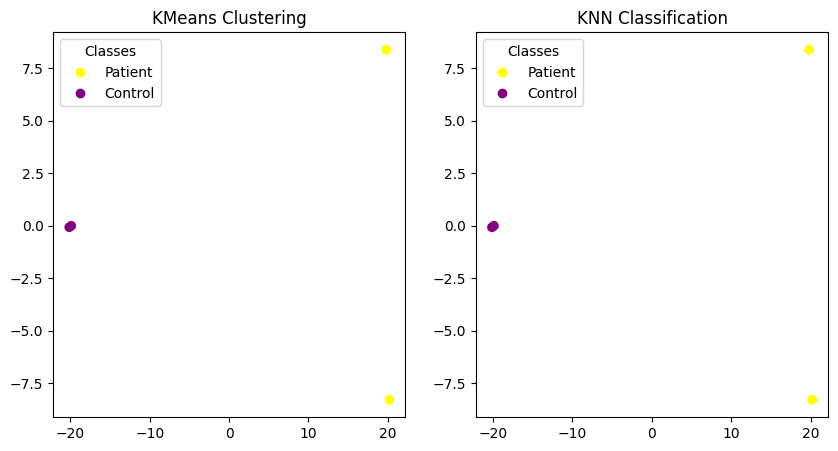

In [24]:
# Reduce data to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test)

colors = ['yellow', 'purple']
labels = ['Patient', 'Control']

# Scatter plot for KMeans
plt.figure(figsize=(10,5))
plt.subplot(121)
scatter = plt.scatter(principalComponents[:,0], principalComponents[:,1], c=kmeans_preds, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('KMeans Clustering')
plt.legend(handles=scatter.legend_elements()[0], labels=labels, title="Classes")

# Scatter plot for KNN
plt.subplot(122)
scatter = plt.scatter(principalComponents[:,0], principalComponents[:,1], c=knn_preds, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('KNN Classification')
plt.legend(handles=scatter.legend_elements()[0], labels=labels, title="Classes")

plt.show()

**Kohonen Networks / SOMs:** They are used for dimensionality reduction and visualization of high-dimensional data. They learn through competitive learning and preserve the topology of the input data.

**K-Means:** It is used for data clustering. It's an iterative algorithm that divides a data set into k non-overlapping subsets (clusters) based on their similarity. Unlike SOMs, K-Means does not preserve the topology of the input data.

**K-Nearest Neighbors (KNN):** It is used for both classification and regression. It works by finding the distances between a query and all the examples in the data, selecting the closest examples to the query. Unlike K-Means and SOMs, KNN is a type of instance-based or lazy learning.

In summary, these techniques are used to find relationships in the data, but they do so in different ways and are suited to different types of problems.